# League of Legends Item Balancing: Further Work Edition
### Capstone Project 1: Data Storytelling

This is the same process as the original capstone project, only now on newer data.

The overarching question: How would a developer for this game know when they need to change an item?

This notebook walks through the data, some easy trends, and poses questions for analysis.

### Data

Champions: This is information on the playable characters in the game. 

Items: This is information on the purchasable items in the game.

Match Data: This is information on games themselves, including played champions, final items bought, when the final items were bought, etc. 

In [1]:
import math
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [109]:
import warnings
warnings.simplefilter('once', category=UserWarning)

Define league and division constants

In [2]:
from itertools import product

leagues = ['GOLD', 'PLATINUM', 'DIAMOND']
divisions = ['IV', 'III', 'II', 'I']

leagues_and_divisions = list(product(leagues, divisions))
leagues_and_divisions

[('GOLD', 'IV'),
 ('GOLD', 'III'),
 ('GOLD', 'II'),
 ('GOLD', 'I'),
 ('PLATINUM', 'IV'),
 ('PLATINUM', 'III'),
 ('PLATINUM', 'II'),
 ('PLATINUM', 'I'),
 ('DIAMOND', 'IV'),
 ('DIAMOND', 'III'),
 ('DIAMOND', 'II'),
 ('DIAMOND', 'I')]

#### Champions

This is the champion table. There are 141 playable champions.

In [3]:
champions_min_df = pd.read_csv('../data/champions_min_9.8.1.csv', index_col=0)
champions_min_df.head(2)

name          id  key                 tags  info.attack  \
champion_name                                                              
MonkeyKing     Wukong  MonkeyKing   62      [Fighter, Tank]            8   
Jax               Jax         Jax   24  [Fighter, Assassin]            7   

               info.defense  info.difficulty  info.magic  
champion_name                                             
MonkeyKing                5                3           2  
Jax                       5                5           7

The tag columns of the champion and item dataframes has a problem.

The data looks like a list, but is actually a string. The first entry of the string is '\['.

In [4]:
champions_min_df.loc['Jax', 'tags']

'[Fighter, Assassin]'

I use some Regex to fix this.

In [5]:
filter(lambda x: x != 'u', re.findall('[A-Za-z]\w*', champions_min_df.loc['Jax', 'tags']))

['Fighter', 'Assassin']

In [6]:
champions_min_df['tags'] = [filter(lambda x: x != 'u', re.findall('[A-Za-z]\w*', champions_min_df.loc[champion, 'tags']))\
                            for champion in champions_min_df.index]

Now, the data is a list of strings!

In [7]:
champions_min_df.loc['Jax', 'tags']

['Fighter', 'Assassin']

In [8]:
champions_min_df.to_csv('../data/champions_min_9.8.1.csv', encoding='utf-8')

In [9]:
len(champions_min_df)

143

Example champion

In [10]:
champions_min_df[champions_min_df['key'] == 41]

name         id  key       tags  info.attack  \
champion_name                                                      
Gangplank      Gangplank  Gangplank   41  [Fighter]            7   

               info.defense  info.difficulty  info.magic  
champion_name                                             
Gangplank                 6                9           4

#### Items

This is the item table. There are 237 items in it, but most of them will not be used for this analysis.

In [11]:
items_df = pd.read_csv('../data/items_9.8.1.csv', encoding='utf-8', index_col=0)
items_df.head(2)

name                                        description  \
item_id                                                                      
1001     Boots of Speed  <groupLimit>Limited to 1 pair of boots.</group...   
1004       Faerie Charm  <stats><mana>+25% Base Mana Regen </mana></stats>   

        consumed  base_gold  depth    sr  effect1amount  effect2amount  \
item_id                                                                  
1001           0        300    0.0  True            0.0            0.0   
1004           0        125    0.0  True            0.0            0.0   

         effect3amount  effect4amount    ...      flat_hp_regen_mod  \
item_id                                  ...                          
1001               0.0            0.0    ...                    0.0   
1004               0.0            0.0    ...                    0.0   

         flat_magic_dmg_mod  flat_ms_mod  flat_phys_dmg_mod  \
item_id                                                       
1001                    0.0         25.0                0.0   
1004                    0.0          0.0                0.0   

        flat_spellblock_mod flat_pct_atk_speed_mod  pct_lifesteal_mod  \
item_id                                                                 
1001                    0.0                    0.0                0.0   
1004                    0.0                    0.0                0.0   

         pct_movespeed_mod         tags  full_item  
item_id                                             
1001                   0.0      [Boots]      False  
1004                   0.0  [ManaRegen]      False  

[2 rows x 34 columns]

In [12]:
items_df.columns

Index([u'name', u'description', u'consumed', u'base_gold', u'depth', u'sr',
       u'effect1amount', u'effect2amount', u'effect3amount', u'effect4amount',
       u'effect5amount', u'effect6amount', u'effect7amount', u'effect8amount',
       u'from', u'into', u'gold_purchasable', u'total_gold', u'req_champion',
       u'special_recipe', u'stacks', u'flat_armor_mod',
       u'flat_crit_chance_mod', u'flat_hp_pool_mod', u'flat_hp_regen_mod',
       u'flat_magic_dmg_mod', u'flat_ms_mod', u'flat_phys_dmg_mod',
       u'flat_spellblock_mod', u'flat_pct_atk_speed_mod', u'pct_lifesteal_mod',
       u'pct_movespeed_mod', u'tags', u'full_item'],
      dtype='object')

Average Pick Rate in a Vacuum?

In [13]:
6.0/len(items_df[items_df['gold_purchasable'] == True])

0.028985507246376812

In [14]:
len(items_df)

243

So items that don't build into or don't build from anything will have a string entry of '0'.

If they do have into or from entries, it will be a list of strings.

In [15]:
items_df.loc[1001, 'from']

u'0'

In [16]:
type(items_df.loc[1001, 'from'])

unicode

In [17]:
items_df['into'].head(1)

item_id
1001    [u'3006', u'3047', u'3020', u'3158', u'3111', ...
Name: into, dtype: object

In [18]:
eval(items_df.loc[1001, 'from'])

0

In [19]:
eval(items_df.loc[3008, 'from'])[0]

u'3073'

I want a boolean column to identify final items (items that do not build into other items). 

In [20]:
final_item = []
ornn_items = ['3371', '3373', '3374', '3379', '3380', '3382', '3383', '3384', '3386']

for into_list in items_df['into']:
    if (type(eval(into_list)) == int) and (eval(into_list) == 0) or ((type(eval(into_list)) == list) and eval(into_list)[0] in ornn_items):
        final_item.append(True)
    else:
        final_item.append(False)

In [21]:
items_df['full_item'] = final_item

In [22]:
items_df['full_item'].value_counts()

True     162
False     81
Name: full_item, dtype: int64

After creating this column, I can restrict my analyses to only 'final' items.

The edge case shown below is the set of Ornn special items. They are built out of some normally finished items, but are generally not available. Abyssal Mask (id 3001) normally does not build into anything, but can be built into Infernal Mask (id 3379) under certain uncommon conditions. Abyssal Mask should still be considered a final item for the purposes on the analysis.

In [23]:
items_df[(items_df['full_item'] == True) &
         (items_df['total_gold'] != 0)].loc[3371:3390,['name', 'base_gold', 'total_gold', 'tags']]

name  base_gold  total_gold  \
item_id                                                      
3371                    Molten Edge          0        3400   
3373                 Forgefire Cape          0        2750   
3374           Rabadon's Deathcrown          0        3600   
3379                  Infernal Mask          0        3000   
3380           The Obsidian Cleaver          0        3000   
3382                      Salvation          0        2100   
3383     Circlet of the Iron Solari          0        2200   
3384                 Trinity Fusion          0        3733   
3386               Zhonya's Paradox          0        2900   
3387                    Frozen Fist          0        2700   
3388           Youmuu's Wraithblade          0        2900   
3389       Might of the Ruined King          0        3300   
3390                  Luden's Pulse          0        3200   

                                                      tags  
item_id                                                     
3371                              [Damage, CriticalStrike]  
3373                                       [Health, Armor]  
3374                                         [SpellDamage]  
3379     [Health, SpellBlock, HealthRegen, Mana, ManaRe...  
3380     [ArmorPenetration, CooldownReduction, Damage, ...  
3382     [Health, HealthRegen, ManaRegen, CooldownReduc...  
3383                           [SpellBlock, Armor, Active]  
3384     [Health, Damage, AttackSpeed, Mana, CooldownRe...  
3386       [Armor, SpellDamage, Active, CooldownReduction]  
3387                [Armor, Mana, CooldownReduction, Slow]  
3388     [Damage, Active, CooldownReduction, NonbootsMo...  
3389     [Damage, AttackSpeed, LifeSteal, Active, Slow,...  
3390         [SpellDamage, Mana, CooldownReduction, OnHit]

In [24]:
items_df.loc[3000:,:][['name', 'base_gold', 'total_gold', 'into', 'full_item', 'tags']].head()

name  base_gold  total_gold       into  \
item_id                                                                       
3001                         Abyssal Mask       1180        3000  [u'3379']   
3003                    Archangel's Staff       1050        3200          0   
3004                             Manamune        675        2400          0   
3006                  Berserker's Greaves        500        1100          0   
3007     Archangel's Staff (Quick Charge)       1050        3200          0   

         full_item                                               tags  
item_id                                                                
3001          True  [Health, SpellBlock, HealthRegen, Mana, ManaRe...  
3003          True  [SpellDamage, Mana, ManaRegen, CooldownReduction]  
3004          True                   [Damage, Mana, ManaRegen, OnHit]  
3006          True                               [AttackSpeed, Boots]  
3007          True  [SpellDamage, Mana, ManaRegen, CooldownReduction]

Need to convert the tags column into a list of strings, just as I did for the champion tags.

This actually needs to be redone every time the dataframe is read from .csv

In [25]:
filter(lambda x: x != 'u', re.findall('[A-Za-z]\w*', items_df.loc[3800, 'tags']))

[u'Health',
 u'HealthRegen',
 u'Armor',
 u'Mana',
 u'Active',
 u'CooldownReduction',
 u'Slow',
 u'NonbootsMovement']

In [26]:
items_df['tags'] = [filter(lambda x: x != 'u', re.findall('[A-Za-z]\w*', items_df.loc[item_id, 'tags']))\
                    for item_id in items_df.index]

In [27]:
items_df[(items_df['full_item'] == True) & (items_df['total_gold'] != 0)][['name', 'base_gold', 'total_gold', 'tags']].tail()

name  base_gold  total_gold  \
item_id                                           
3800     Righteous Glory       1100        2650   
3812       Death's Dance        625        3500   
3814       Edge of Night        625        3000   
3905        Twin Shadows        650        2400   
3907         Spellbinder        800        2900   

                                                      tags  
item_id                                                     
3800     [Health, HealthRegen, Armor, Mana, Active, Coo...  
3812                [Damage, LifeSteal, CooldownReduction]  
3814            [Health, Damage, Active, ArmorPenetration]  
3905     [SpellDamage, Active, CooldownReduction, Slow,...  
3907               [SpellDamage, Active, NonbootsMovement]

In [28]:
items_df.to_csv('../data/items_9.8.1.csv', encoding='utf-8')

### Match Data

I will import Gold IV for testing, but the goal is to build a function that can do everything I want on each league and division separately.

In [29]:
matches_df = pd.read_csv('../data/matches_GOLD_IV.csv', index_col=0)
print("Number of games: %d" % (len(matches_df)/10))
matches_df.head()

Number of games: 1165


championId highestAchievedSeasonTier  participantId  spell1Id  spell2Id  \
0          78                  UNRANKED              1         4        12   
1         236                  UNRANKED              2         4         7   
2         412                      GOLD              3         4        14   
3         254                      GOLD              4         4        11   
4         103                      GOLD              5        14         4   

   stats.assists  stats.champLevel  stats.combatPlayerScore  \
0              5                13                        0   
1              3                 9                        0   
2              9                10                        0   
3              7                13                        0   
4              4                13                        0   

   stats.damageDealtToObjectives  stats.damageDealtToTurrets  \
0                           4207                        2669   
1                           1935                        1508   
2                            473                           0   
3                           5893                        1369   
4                            508                         452   

                ...                timeline.goldPerMinDeltas.20-30  \
0               ...                                            NaN   
1               ...                                            NaN   
2               ...                                            NaN   
3               ...                                            NaN   
4               ...                                            NaN   

   timeline.xpDiffPerMinDeltas.20-30  timeline.xpPerMinDeltas.20-30  \
0                                NaN                            NaN   
1                                NaN                            NaN   
2                                NaN                            NaN   
3                                NaN                            NaN   
4                                NaN                            NaN   

   timeline.creepsPerMinDeltas.30-end  timeline.csDiffPerMinDeltas.30-end  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

  timeline.damageTakenDiffPerMinDeltas.30-end  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

  timeline.damageTakenPerMinDeltas.30-end  timeline.goldPerMinDeltas.30-end  \
0                                     NaN                               NaN   
1                                     NaN                               NaN   
2                                     NaN                               NaN   
3                                     NaN                               NaN   
4                                     NaN                               NaN   

   timeline.xpDiffPerMinDeltas.30-end  timeline.xpPerMinDeltas.30-end  
0                                 NaN                             NaN  
1                                 NaN                             NaN  
2                                 NaN                             NaN  
3                                 NaN                             NaN  
4                                 NaN                             NaN  

[5 rows x 141 columns]

## Build an item-indexed dataframe

This dataframe will contain descriptive statistics on the purchase rate, win rate, and unique spread of champions that build each item. It is a set of aggregations on the match data table.

I will make a separate dataframe for each league and division, and compile the following cells into a single function.

This way, I can use the same logic for each league and division.

### Pick Rate (related to count)

How often an item is purchased.

In [30]:
match_items = pd.DataFrame(matches_df[['stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                          'stats.item4', 'stats.item5', 'stats.item6']].stack().reset_index(drop=True),
                          columns=['item_id'])

In [31]:
item_occ = pd.DataFrame(match_items.groupby('item_id').size(),
                        columns=['count'])

In [32]:
item_occ['pick_rate'] = item_occ['count']/len(matches_df)
item_occ.head()

count  pick_rate
item_id                  
0         7094   0.608927
1001       557   0.047811
1004       112   0.009614
1006        60   0.005150
1011       325   0.027897

### Champion spread

How many different champions build an item.

In [33]:
match_min_df = pd.DataFrame(matches_df[['championId', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                                        'stats.item4', 'stats.item5', 'stats.item6']])

In [34]:
item_stack_sub_dfs = []
for col_name in match_min_df.columns[1:]:
    sub_df = match_min_df[['championId', col_name]]
    sub_df.columns = ['championId', 'item_id']
    item_stack_sub_dfs.append(sub_df)
    
item_stack_df = pd.concat(item_stack_sub_dfs)

In [35]:
print("With " + str(len(matches_df)/10) + " games at 10 players per game, and 7 items per player, we find " +
      str(len(item_stack_df)) + " combinations of champions and single items.")

With 1165 games at 10 players per game, and 7 items per player, we find 81550 combinations of champions and single items.


In [36]:
print("However, only " + str(len(item_stack_df.drop_duplicates())) + " of the combinations are unique.")

However, only 7960 of the combinations are unique.


In [37]:
champion_spread = item_stack_df.drop_duplicates().groupby('item_id').size()

In [38]:
item_occ['spread'] = champion_spread

In [39]:
item_occ.head()

count  pick_rate  spread
item_id                          
0         7094   0.608927     144
1001       557   0.047811     128
1004       112   0.009614      26
1006        60   0.005150      37
1011       325   0.027897      72

### Win rate

How often a player wins a game with an item, given that they have built the item.

Below, for a single game, one team of five players will win, and the other will lose.

In [40]:
items_and_wins_df = matches_df[['stats.win', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                                        'stats.item4', 'stats.item5', 'stats.item6']]
items_and_wins_df.head(10)

stats.win  stats.item0  stats.item1  stats.item2  stats.item3  stats.item4  \
0      False         1054         3068         1001         3025         1029   
1      False         3153         1055         3044         1001            0   
2      False         3069         3117         3190            0         2010   
3      False         3047         1412         3078         3052            0   
4      False         1056         3165            0         2031         3285   
5       True         2033         1031         3111         1011         3078   
6       True         3147         3401         3142         3117         1038   
7       True         1416         3077         3144         3078         3111   
8       True         1056         3285         3020         3916            0   
9       True         1037         3095         3031         3006         3094   

   stats.item5  stats.item6  
0         1029         3340  
1            0         3340  
2            0         3364  
3            0         3364  
4         3020         3340  
5         1082         3340  
6            0         3364  
7         1042         3340  
8            0         3363  
9         3035         3340

In [41]:
item_win_sub_dfs = []
for col_name in items_and_wins_df.columns[1:]:
    sub_df = items_and_wins_df[['stats.win', col_name]]
    sub_df.columns = ['stats.win', 'item_id']
    item_win_sub_dfs.append(sub_df)

DataFrame of # of wins with each item

In [42]:
item_win_df = pd.concat(item_win_sub_dfs)
item_win_df.columns = ['wins', 'item_id']
item_occ['wins'] = item_win_df.groupby('item_id').sum()['wins']
item_occ.head()

count  pick_rate  spread    wins
item_id                                  
0         7094   0.608927     144  3061.0
1001       557   0.047811     128   194.0
1004       112   0.009614      26    50.0
1006        60   0.005150      37    26.0
1011       325   0.027897      72   169.0

In [43]:
item_occ['win_rate'] = item_occ['wins']/item_occ['count']
item_occ.head()

count  pick_rate  spread    wins  win_rate
item_id                                            
0         7094   0.608927     144  3061.0  0.431491
1001       557   0.047811     128   194.0  0.348294
1004       112   0.009614      26    50.0  0.446429
1006        60   0.005150      37    26.0  0.433333
1011       325   0.027897      72   169.0  0.520000

In [44]:
#item_occ.to_csv('../data/item_occurrences_8.22.1.csv', encoding='utf-8')

These are all the statistics needed for an initial analysis. Joining to the item table on item_id makes the table readable for me.

In [45]:
item_occ = item_occ.join(items_df[['name', 'full_item', 'total_gold', 'tags']])
item_occ.tail()

count  pick_rate  spread   wins  win_rate           name full_item  \
item_id                                                                       
3814        70   0.006009      17   38.0  0.542857  Edge of Night      True   
3905       147   0.012618      26   84.0  0.571429   Twin Shadows      True   
3907        75   0.006438      25   44.0  0.586667    Spellbinder      True   
3916       201   0.017253      52  111.0  0.552239   Oblivion Orb     False   
3931         1   0.000086       1    1.0  1.000000            NaN       NaN   

         total_gold                                               tags  
item_id                                                                 
3814         3000.0         [Health, Damage, Active, ArmorPenetration]  
3905         2400.0  [SpellDamage, Active, CooldownReduction, Slow,...  
3907         2900.0            [SpellDamage, Active, NonbootsMovement]  
3916         1600.0            [Health, MagicPenetration, SpellDamage]  
3931            NaN                                                NaN

Examining the most commonly picked items. 60% of players in Gold IV finish the game with an empty inventory slot (item_id 0).

The 7 most common items are all Trinkets (the 3 options for item slot 6) or Boot items (each player generally builds 1 per game).

In [46]:
item_occ.sort_values('count', ascending=False).head(15)

count  pick_rate  spread    wins  win_rate                     name  \
item_id                                                                        
3340      7269   0.623948     144  3548.0  0.488100  Warding Totem (Trinket)   
0         7094   0.608927     144  3061.0  0.431491                      NaN   
3364      2953   0.253476     136  1543.0  0.522519              Oracle Lens   
3020      2326   0.199657      71  1207.0  0.518917         Sorcerer's Shoes   
3006      2210   0.189700      48  1141.0  0.516290      Berserker's Greaves   
3047      2138   0.183519     132  1037.0  0.485033               Ninja Tabi   
3111      1850   0.158798     133   952.0  0.514595         Mercury's Treads   
1055      1476   0.126695      59   688.0  0.466125            Doran's Blade   
3031      1468   0.126009      36   790.0  0.538147            Infinity Edge   
3363      1399   0.120086     124   719.0  0.513939      Farsight Alteration   
2031      1352   0.116052     133   625.0  0.462278        Refillable Potion   
3117      1330   0.114163      71   707.0  0.531579        Boots of Mobility   
3071      1253   0.107554      46   654.0  0.521947        The Black Cleaver   
3285      1205   0.103433      48   624.0  0.517842             Luden's Echo   
3157      1176   0.100944      64   622.0  0.528912       Zhonya's Hourglass   

        full_item  total_gold  \
item_id                         
3340         True         0.0   
0             NaN         NaN   
3364         True         0.0   
3020         True      1100.0   
3006         True      1100.0   
3047         True      1100.0   
3111         True      1100.0   
1055         True       450.0   
3031         True      3400.0   
3363         True         0.0   
2031        False       150.0   
3117         True       900.0   
3071         True      3000.0   
3285        False      3200.0   
3157         True      2900.0   

                                                      tags  
item_id                                                     
3340               [Active, Jungle, Lane, Trinket, Vision]  
0                                                      NaN  
3364                             [Active, Trinket, Vision]  
3020                             [Boots, MagicPenetration]  
3006                                  [AttackSpeed, Boots]  
3047                                        [Armor, Boots]  
3111                         [Boots, SpellBlock, Tenacity]  
1055                     [Damage, Health, Lane, LifeSteal]  
3031                              [CriticalStrike, Damage]  
3363                             [Active, Trinket, Vision]  
2031       [HealthRegen, Consumable, Active, Lane, Jungle]  
3117                                               [Boots]  
3071     [ArmorPenetration, CooldownReduction, Damage, ...  
3285         [SpellDamage, Mana, CooldownReduction, OnHit]  
3157       [Armor, SpellDamage, Active, CooldownReduction]

#### Item-Indexed DF Builder

In [47]:
def build_item_stats_df(league, division):
    """
    For the given league and division,
    Build the dataframe with item statistics
    When finished, save at item_stats_<league>_<division>.csv
    """
    # Read in data
    input_filepath = '../data/matches_' + league + '_' + division + '.csv'
    matches_df = pd.read_csv(input_filepath, index_col=0)
    
    # Number of occurrences
    match_items = pd.DataFrame(matches_df[['stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                                           'stats.item4', 'stats.item5', 'stats.item6']].stack().reset_index(drop=True),
                               columns=['item_id'])
    
    # Start final dataframe
    item_occ = pd.DataFrame(match_items.groupby('item_id').size(), columns=['count'])
    
    # Define pick rate with the idea that no item is built more than once
    # Only works for final items
    item_occ['pick_rate'] = item_occ['count']/len(matches_df)
    
    # Champion spread
    match_min_df = pd.DataFrame(matches_df[['championId', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                                            'stats.item4', 'stats.item5', 'stats.item6']])
    # Stack the item columns, repeat the championId
    item_stack_sub_dfs = []
    for col_name in match_min_df.columns[1:]:
        sub_df = match_min_df[['championId', col_name]]
        sub_df.columns = ['championId', 'item_id']
        item_stack_sub_dfs.append(sub_df)
    
    # Look for unique combinations of champion / item
    item_stack_df = pd.concat(item_stack_sub_dfs)
    champion_spread = item_stack_df.drop_duplicates().groupby('item_id').size()
    item_occ['spread'] = champion_spread
    
    # Win Rate
    items_and_wins_df = matches_df[['stats.win', 'stats.item0', 'stats.item1', 'stats.item2', 'stats.item3',
                                    'stats.item4', 'stats.item5', 'stats.item6']]
    # Stack the item columns, repeat the boolean with win / loss data
    item_win_sub_dfs = []
    for col_name in items_and_wins_df.columns[1:]:
        sub_df = items_and_wins_df[['stats.win', col_name]]
        sub_df.columns = ['stats.win', 'item_id']
        item_win_sub_dfs.append(sub_df)
    
    # Track how many times the item showed up with a win
    # Divide by how many times the item showed up
    item_win_df = pd.concat(item_win_sub_dfs)
    item_win_df.columns = ['wins', 'item_id']
    item_occ['wins'] = item_win_df.groupby('item_id').sum()['wins']
    item_occ['win_rate'] = item_occ['wins']/item_occ['count']
    
    # Save data
    output_filepath = '../data/item_stats_' + league + '_' + division + '.csv'
    item_occ.to_csv(output_filepath)
    
    # Print message to indicate the function finished
    print("Compilation of Item Statistics Finished for %s %s" % (league, division))

In [103]:
build_item_stats_df(leagues[0], divisions[0])

Compilation of Item Statistics Finished for GOLD IV


In [48]:
%%time
for league, division in leagues_and_divisions:
    build_item_stats_df(league, division)

Compilation of Item Statistics Finished for GOLD IV
Compilation of Item Statistics Finished for GOLD III


C:\Users\sebia\Miniconda2\lib\site-packages\IPython\core\magic.py:188: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


Compilation of Item Statistics Finished for GOLD II
Compilation of Item Statistics Finished for GOLD I
Compilation of Item Statistics Finished for PLATINUM IV
Compilation of Item Statistics Finished for PLATINUM III
Compilation of Item Statistics Finished for PLATINUM II
Compilation of Item Statistics Finished for PLATINUM I
Compilation of Item Statistics Finished for DIAMOND IV
Compilation of Item Statistics Finished for DIAMOND III
Compilation of Item Statistics Finished for DIAMOND II
Compilation of Item Statistics Finished for DIAMOND I
Wall time: 3.15 s


In [49]:
for league, division in leagues_and_divisions:
    input_filepath = '../data/item_stats_' + league + '_' + division + '.csv'
    ld_df = pd.read_csv(input_filepath, index_col=0)
    print(ld_df.head())

         count  pick_rate  spread    wins  win_rate
item_id                                            
0         7094   0.608927     144  3061.0  0.431491
1001       557   0.047811     128   194.0  0.348294
1004       112   0.009614      26    50.0  0.446429
1006        60   0.005150      37    26.0  0.433333
1011       325   0.027897      72   169.0  0.520000
         count  pick_rate  spread    wins  win_rate
item_id                                            
0         6789   0.581748     144  2898.0  0.426867
1001       452   0.038732     123   174.0  0.384956
1004       109   0.009340      23    35.0  0.321101
1006        50   0.004284      33    22.0  0.440000
1011       311   0.026650      70   163.0  0.524116
         count  pick_rate  spread    wins  win_rate
item_id                                            
0         6906   0.598129     144  2948.0  0.426875
1001       505   0.043738     125   168.0  0.332673
1004        82   0.007102      21    28.0  0.341463
1006        

Awesome! Item statistics have been collected.

Now I need to think about how I want to visualize the data across the leagues and divisions.

So the empty item slot has a pick rate over 1, which is fine. Does anything else?

In [50]:
test_df = pd.read_csv('../data/item_stats_GOLD_IV.csv', index_col=0).join(items_df[['name', 'full_item', 'total_gold', 'tags']])
test_df.sort_values('pick_rate').tail()

count  pick_rate  spread    wins  win_rate                     name  \
item_id                                                                        
3006      2210   0.189700      48  1141.0  0.516290      Berserker's Greaves   
3020      2326   0.199657      71  1207.0  0.518917         Sorcerer's Shoes   
3364      2953   0.253476     136  1543.0  0.522519              Oracle Lens   
0         7094   0.608927     144  3061.0  0.431491                      NaN   
3340      7269   0.623948     144  3548.0  0.488100  Warding Totem (Trinket)   

        full_item  total_gold                                     tags  
item_id                                                                 
3006         True      1100.0                     [AttackSpeed, Boots]  
3020         True      1100.0                [Boots, MagicPenetration]  
3364         True         0.0                [Active, Trinket, Vision]  
0             NaN         NaN                                      NaN  
3340         True         0.0  [Active, Jungle, Lane, Trinket, Vision]

## Plots

Let's visualize the distribution of item occurrences.

The x-axis is the item ID, a unique identifier for each item.

In [60]:
def plot_for_each(leagues, divisions, plot_type, y_col, x_col=None, include_item_data=False):
    """
    Function to make a plot_type for each entry in leagues and divisions
    Plot x_col and y_col
    """
    
    figsize_x = len(divisions) * 3
    figsize_y = len(leagues) * 3
    
    # Set up figure
    # It will have a row for each league and a column for each division
    fig, axes = plt.subplots(len(leagues), len(divisions), sharex='col', sharey='row', figsize=(figsize_x, figsize_y))
    
    for col, league in enumerate(leagues):
        
        #axes[0][league].ylabel
        
        for row, division in enumerate(divisions):
            
            input_filepath = "../data/item_stats_" + league + "_" + division + ".csv"
            df = pd.read_csv(input_filepath, index_col=0)
            
            if include_item_data:
                df = df.join(pd.read_csv('../data/items_9.8.1.csv', index_col=0)[['name', 'full_item', 'total_gold', 'tags']])
            
            # plot x_col and y_col
            fig = df.plot(x=x_col, 
                          y=y_col, 
                          kind=plot_type, 
                          ax=axes[col][row])
            
            # Set title for each plot
            # RE_EXAMINE
            axes[col][row].set_title("%s %s" % (league, division))
            
    
    
    fig = plt.tight_layout()
    #fig.suptitle("", fontsize=)
    
    return fig

In [61]:
def hist_for_each(leagues, divisions, y_col, bins, include_item_data=False):
    """
    Function to make a histogram for each entry in leagues and divisions
    """
    
    figsize_x = len(divisions) * 3
    figsize_y = len(leagues) * 3
    
    # Set up figure
    # It will have a row for each league and a column for each division
    fig, axes = plt.subplots(len(leagues), len(divisions), sharex='col', sharey='row', figsize=(figsize_x, figsize_y))
    
    for col, league in enumerate(leagues):
        
        #axes[0][league].ylabel
        
        for row, division in enumerate(divisions):
            
            input_filepath = "../data/item_stats_" + league + "_" + division + ".csv"
            df = pd.read_csv(input_filepath, index_col=0)
            
            if include_item_data:
                df = df.join(pd.read_csv('../data/items_9.8.1.csv', index_col=0)[['name', 'full_item', 'total_gold', 'tags']])
                
            # plot x_col and y_col
            fig = df.plot(y=y_col, 
                          kind='hist',
                          bins=bins,
                          ax=axes[col][row])
            
            # Set title for each plot
            # RE_EXAMINE
            axes[col][row].set_title("%s %s" % (league, division))
            
    
    
    fig = plt.tight_layout()
    #fig.suptitle("", fontsize=)
    
    return fig

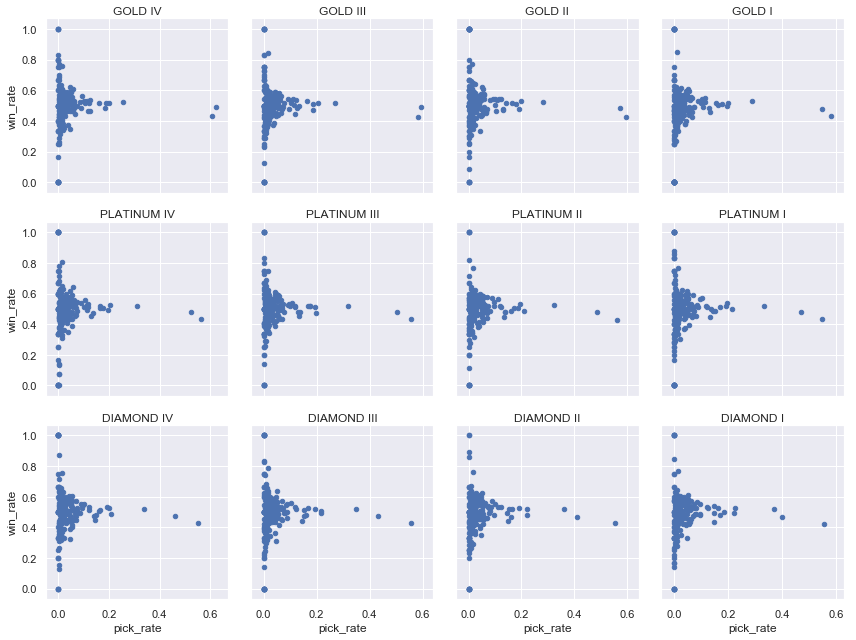

In [62]:
_ = plot_for_each(leagues, divisions, 'scatter', 'win_rate', 'pick_rate')
plt.show()

Above, we can see that the general trend that high pick rate items have win rates very close to 50%. Higher leagues actually see many high pick rate items with lower than average win rates.

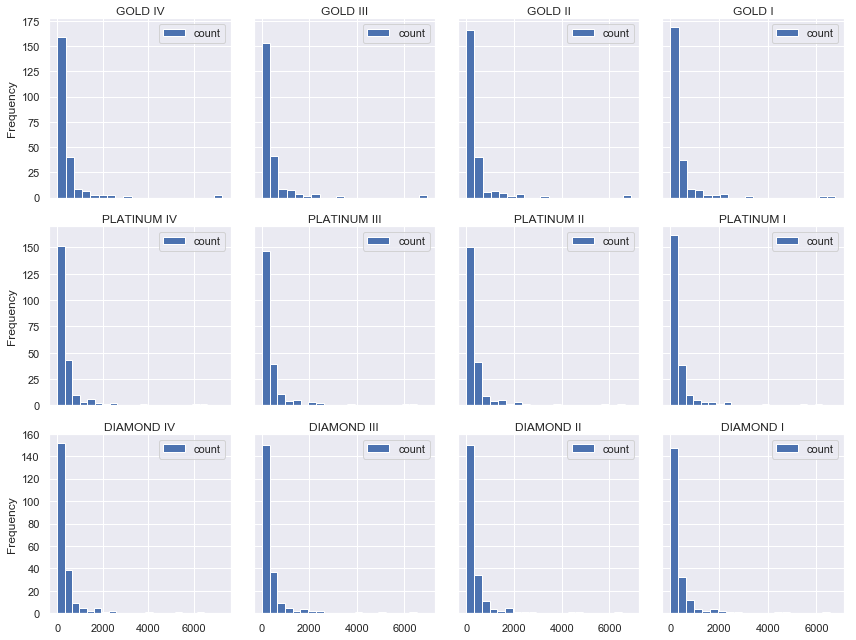

In [63]:
_ = hist_for_each(leagues, divisions, 'count', 20)
plt.show()

The histograms of pick rates / count frequencies are very similar across leagues and divisions. Higher leagues tend to have fewer high outliers, but a longer tail to the distribution.

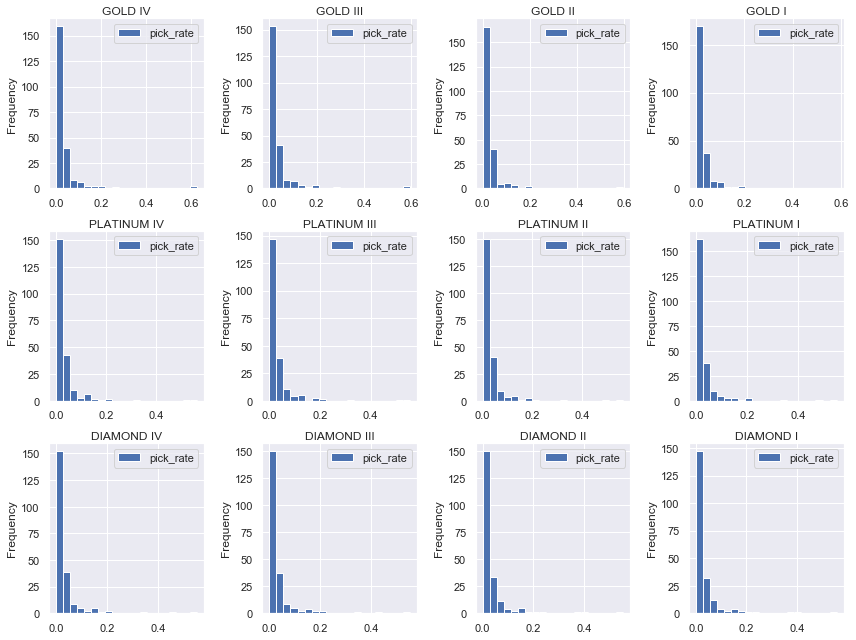

In [54]:
_ = hist_for_each(leagues, divisions, 'pick_rate', 20)
plt.show()

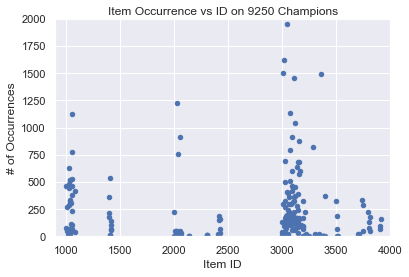

In [158]:
item_occ.reset_index().plot(x='item_id' , y='count', kind='scatter',
                            title='Item Occurrence vs ID on 9250 Champions',
                            xlim=[900, 4000], ylim=[0, 2000])
plt.ylabel('# of Occurrences')
plt.xlabel('Item ID')
plt.savefig('../analysis_images/item_occurrence_vs_id.png')

### Pick Rate

This is exactly proportional to counts, just normalized by the number of item slots in the dataframe (7 * 9250).

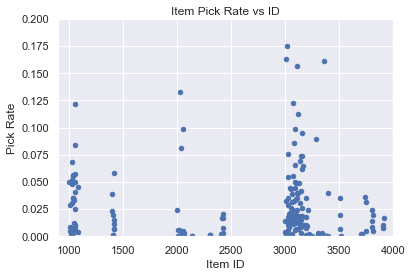

In [159]:
item_occ.reset_index().plot(x='item_id' , y='pick_rate', kind='scatter',
                            title='Item Pick Rate vs ID', xlim=[900, 4000], ylim=[0, 0.2])
#plt.plot(np.linspace(900, 4000, num=50),
#         np.full(50, 6.0/len(items_df[items_df['gold_purchasable'] == True])),
#         'k--')
plt.ylabel('Pick Rate')
plt.xlabel('Item ID')
plt.savefig('../analysis_images/item_pick_rate_vs_id.png')

In [160]:
len(item_occ)

208

In [161]:
6 / (1.0 * len(item_occ))

0.028846153846153848

In [162]:
item_occ.pick_rate.mean()

0.03365384615384617

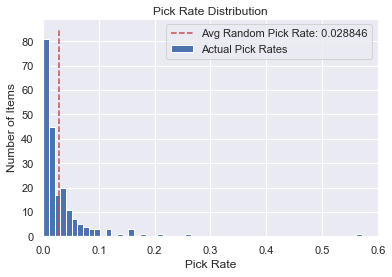

In [163]:
item_occ['pick_rate'].plot.hist(title='Pick Rate Distribution', xlim=[0,0.6], bins=60, label='Actual Pick Rates')
plt.xlabel('Pick Rate')
plt.ylabel('Number of Items')

expected_pick_rate = 6 / (1.0 * len(item_occ))
epr_label = 'Avg Random Pick Rate: %f' % expected_pick_rate
plt.plot(np.full(50, expected_pick_rate), np.linspace(0, 85, num=50), 'r--', label=epr_label)

plt.legend()
plt.savefig('../analysis_images/item_pick_rate_dist.png')

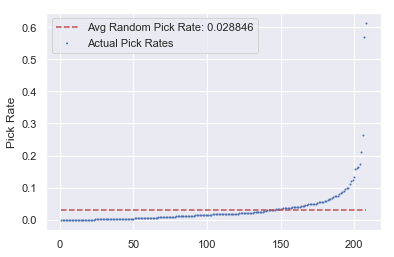

In [164]:
pick_rates = item_occ['pick_rate'].sort_values().values
plt.scatter(x=np.linspace(1, len(pick_rates), len(pick_rates)), y=pick_rates, s=1.0, label='Actual Pick Rates')

plt.plot(np.linspace(1, len(pick_rates), num=50), np.full(50, expected_pick_rate), 'r--', label=epr_label)

plt.legend()
plt.ylabel('Pick Rate')

plt.show()

### Champion Spread

Champion Spread makes sense to correlate with Pick Rate. If more of the 141 champions can viably build an item, then the item should show up more in general.

Below, we see that all leagues have some items at very high (> 0.5) pick rates, with high champion spreads. Higher leagues find some of the high spread items to have higher pick rate than in lower leagues, as evidenced by more points being along the top of the plot.

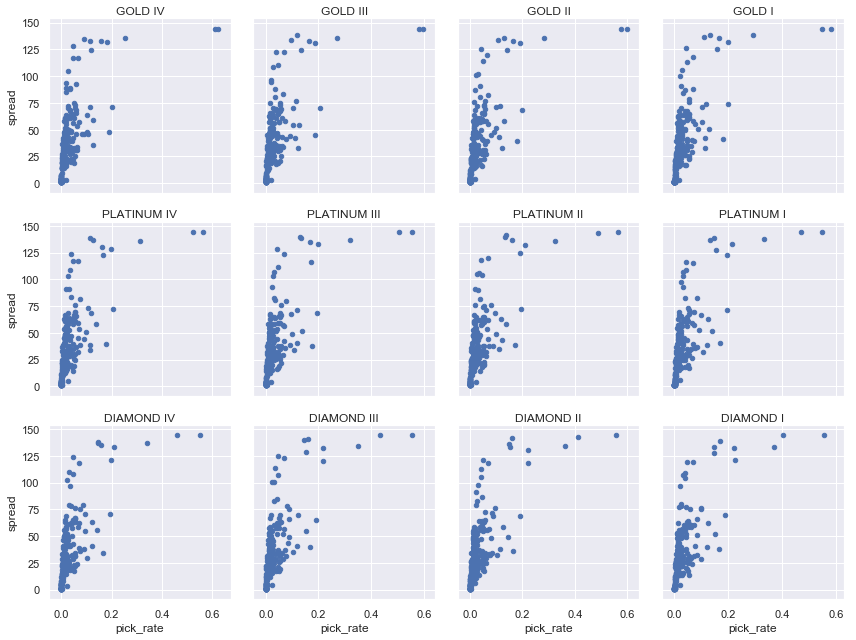

In [64]:
_ = plot_for_each(leagues, divisions, 'scatter', 'spread', 'pick_rate')
plt.show()

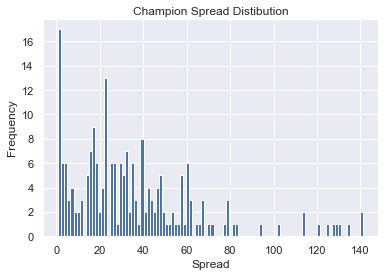

In [167]:
item_occ['spread'].plot.hist(title='Champion Spread Distibution', bins=100)
plt.xlabel('Spread')
plt.savefig('../analysis_images/champion_spread_dist.png')

Make plots showing differences in league / division order

In [ ]:
def get_ld_dfs(leagues, divisions, df_filepaths):
    """
    """
    
    return

In [ ]:
def filter_df_by_item_type(df, item_type):
    """
    """
    
    return

In [122]:
def plot_league_trends(leagues, divisions, trend_col, datapoint_col, df_filter):
    """
    Plot a trend across the different leagues and divisions
    Leagues and divisions will be at set intervals across the x-axis
    The trend will be shown along the y-axis for each datapoint
    By default, the datapoint column is the index
    Filtering for the dataframes can be passed through df_filter
    """
    
    figsize_x = len(divisions) * 3
    figsize_y = len(leagues) * 3
    
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
    
    # Make multiindexed dataframe
    # item id, league, division are the indices
    trend_df_list = []
    
    for col, league in enumerate(leagues):
        
        for row, division in enumerate(divisions):
            
            input_filepath = "../data/item_stats_" + league + "_" + division + ".csv"
            df = pd.read_csv(input_filepath, index_col=0)
            
            if df_filter:
                df = df[[df_filter]]
            
            df.loc[:, 'league'] = league
            df.loc[:, 'division'] = division
            
            trend_df_list.append(df)
    
    trend_df = pd.concat(trend_df_list)
    trend_df = trend_df.set_index(append=True, keys=['league', 'division'])
    
    for item_id in trend_df.index.get_level_values(0).values:
        fig = trend_df.loc[item_id].plot(y='win_rate', ax=ax)
    
    return fig

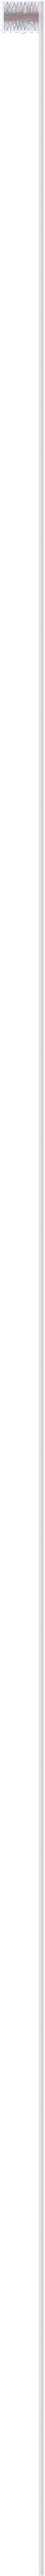

In [123]:
_ = plot_league_trends(leagues, divisions, 'win_rate', 'item_id', None)

LOL

What a terrible plot

### Win Rate

\# of games with item & win / # of games with item. The true average of actual items should be slightly higher than 50%. The average win rate of the empty item slot (item_id of 0) is about 42%, because players without a full of items tend to lose vs players with full sets of items.

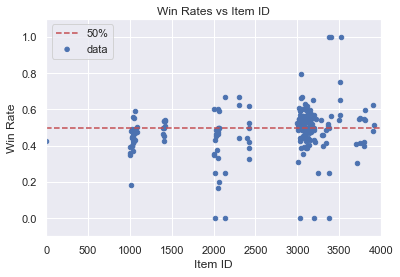

In [168]:
centerline_x = np.linspace(0, 4000, num=50)
centerline_y = np.full(50, 0.5)

item_occ.reset_index().plot(x='item_id', y='win_rate', kind='scatter', xlim=[0, 4000], ylim=[-0.1,1.1], label='data', title='Win Rates vs Item ID')
plt.plot(centerline_x, centerline_y, 'r--', label='50%')
plt.legend(loc=2)
plt.ylabel('Win Rate')
plt.xlabel('Item ID')
plt.savefig('../analysis_images/win_rate_vs_item_id.png')

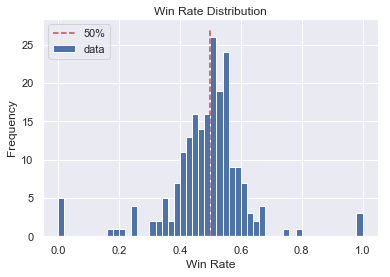

In [169]:
item_occ['win_rate'].plot.hist(title='Win Rate Distribution', bins=50,
                              label='data')
fifty_pct_line_y = np.linspace(0, 27, num = 50)
fifty_pct_line_x = np.full(50, 0.5)
plt.plot(fifty_pct_line_x, fifty_pct_line_y, 'r--', label='50%')
plt.legend(loc=2)
plt.xlabel('Win Rate')
plt.savefig('../analysis_images/win_rate_dist.png')

Remove items with fewer than 5 games in the dataframe. This gets rid of all the values at 0 and 1.0

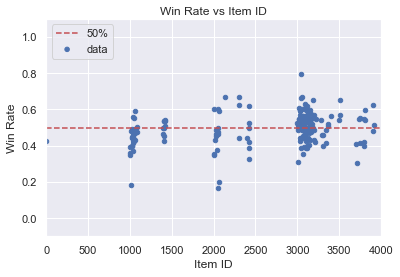

In [170]:
item_occ[item_occ['count'] >= 5].reset_index().plot(x='item_id', y='win_rate', kind='scatter',
                                                  xlim=[0, 4000], ylim=[-0.1,1.1], label='data', title='Win Rate vs Item ID')
plt.plot(centerline_x, centerline_y, 'r--', label='50%')
plt.legend(loc=2)
plt.ylabel('Win Rate')
plt.xlabel('Item ID')
plt.savefig('../analysis_images/win_rate_vs_item_id_clipped.png')

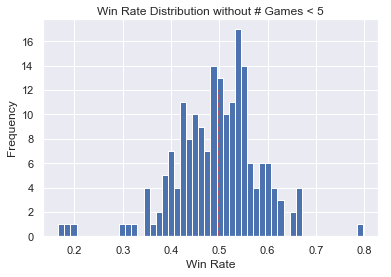

In [171]:
item_occ[item_occ['count'] >= 5]['win_rate'].plot.hist(title='Win Rate Distribution without # Games < 5',
                                                      bins=50, label='data')
fifty_pct_line_y = np.linspace(0, 12, num = 50)
fifty_pct_line_x = np.full(50, 0.5)
plt.plot(fifty_pct_line_x, fifty_pct_line_y, 'r--', label='50%')
plt.xlabel('Win Rate')
plt.savefig('../analysis_images/win_rate_dist_clipped.png')

In [172]:
item_occ.sort_values('win_rate', ascending=False)

count  pick_rate  spread   wins  win_rate  \
item_id                                              
3400         2   0.000216       2    2.0  1.000000   
3520         2   0.000216       2    2.0  1.000000   
3379         1   0.000108       1    1.0  1.000000   
3041       123   0.013297      45   98.0  0.796748   
3513         4   0.000432       4    3.0  0.750000   
3060        18   0.001946      14   12.0  0.666667   
2302         9   0.000973       5    6.0  0.666667   
2140         6   0.000649       6    4.0  0.666667   
3050       140   0.015135      19   93.0  0.664286   
3193        69   0.007459      32   45.0  0.652174   
3512        63   0.006811      22   41.0  0.650794   
3089       414   0.044757      60  260.0  0.628019   
2303         8   0.000865       6    5.0  0.625000   
3907        69   0.007459      28   43.0  0.623188   
2420       154   0.016649      77   95.0  0.616883   
3110       159   0.017189      35   98.0  0.616352   
3087       190   0.020541      29  116.0  0.610526   
3026       503   0.054378      60  307.0  0.610338   
3053       399   0.043135      41  241.0  0.604010   
2004         5   0.000541       3    3.0  0.600000   
2053        45   0.004865      21   27.0  0.600000   
3812       177   0.019135      36  106.0  0.598870   
3102       183   0.019784      48  109.0  0.595628   
3036       136   0.014703      29   81.0  0.595588   
3151       387   0.041838      48  230.0  0.594315   
2065        32   0.003459      17   19.0  0.593750   
3031       697   0.075351      25  412.0  0.591105   
3135       281   0.030378      50  166.0  0.590747   
1058       378   0.040865      55  223.0  0.589947   
3140       136   0.014703      43   80.0  0.588235   
...        ...        ...     ...    ...       ...   
1027        63   0.006811      42   25.0  0.396825   
3082       195   0.021081      60   77.0  0.394872   
1006        46   0.004973      27   18.0  0.391304   
3044       200   0.021622      45   78.0  0.390000   
2424       155   0.016757      61   60.0  0.387097   
3113       122   0.013189      37   47.0  0.385246   
3101        65   0.007027      23   25.0  0.384615   
2045         8   0.000865       7    3.0  0.375000   
1043       110   0.011892      26   41.0  0.372727   
1004        78   0.008432      23   28.0  0.358974   
2003       226   0.024432      83   80.0  0.353982   
3070       105   0.011351      21   37.0  0.352381   
1001       459   0.049622     113  159.0  0.346405   
2010        52   0.005622      27   18.0  0.346154   
2058         3   0.000324       2    1.0  0.333333   
2422        70   0.007568      42   23.0  0.328571   
3004        13   0.001405       3    4.0  0.307692   
3715        23   0.002486      14    7.0  0.304348   
3252         4   0.000432       3    1.0  0.250000   
2013         4   0.000432       3    1.0  0.250000   
2139         4   0.000432       4    1.0  0.250000   
3380         4   0.000432       3    1.0  0.250000   
2059         5   0.000541       2    1.0  0.200000   
1018        11   0.001189      10    2.0  0.181818   
2057         6   0.000649       2    1.0  0.166667   
2138         1   0.000108       1    0.0  0.000000   
3383         2   0.000216       2    0.0  0.000000   
2011         1   0.000108       1    0.0  0.000000   
3200         2   0.000216       1    0.0  0.000000   
3034         1   0.000108       1    0.0  0.000000   

                                      name full_item  total_gold  \
item_id                                                            
3400                            'Your Cut'      True         0.0   
3520                                   NaN       NaN         NaN   
3379                         Infernal Mask      True      4000.0   
3041                   Mejai's Soulstealer      True      1400.0   
3513                                   NaN       NaN         NaN   
3060                                   NaN       NaN         NaN   
2302                                   NaN       NaN         N

### Pick rate vs win rate

My first guess at a correlation is that items that win more often should get picked more often. However, it seems that items that get picked more often are probably more likely to be picked on both teams in a game, and thus will keep closer to a 50% win rate.

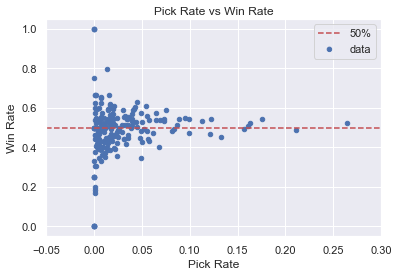

In [173]:
item_occ.plot(x='pick_rate', y='win_rate', kind='scatter', title='Pick Rate vs Win Rate',
             xlim=[-0.05, 0.3], ylim=[-0.05, 1.05], label='data')
plt.plot(np.linspace(-0.05, 0.30, num = 50), np.full(50, 0.5), 'r--', label='50%')
plt.xlabel('Pick Rate')
plt.ylabel('Win Rate')
plt.legend(loc='best')
plt.savefig('../analysis_images/pick_rate_vs_win_rate.png')

### Distributions of item costs

The final analysis will probably only include the more expensive items (full items), which are generally located in the right lobe of the distribution.

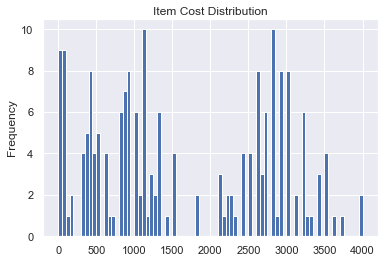

In [174]:
item_occ['total_gold'].plot.hist(title='Item Cost Distribution', bins=80)

I can tell that several of these item costs are for items I don't want to be in my analysis. I will need to have some other cuts to filter them out. I'm guessing they are lane items, boots, potions, etc.

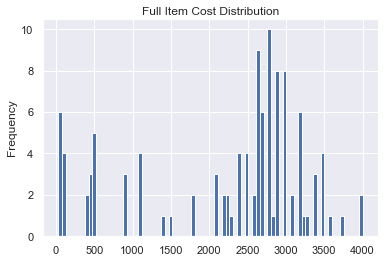

In [175]:
item_occ[(item_occ['full_item'] == True) &
         (item_occ['total_gold'] != 0)]['total_gold'].plot.hist(title='Full Item Cost Distribution', bins=80)

### Pick Rate vs Item Cost

Do more expensive items get picked less often? Not really.

Players generally buy cheaper items more (especially since they build into more items), but this data only includes the last set of items a player had, so it will lean towards the full items that don't get replaced.

The three highest points are the most popular boots. Aside from that, I'm not sure if this is giving me any insights without some information on tags.

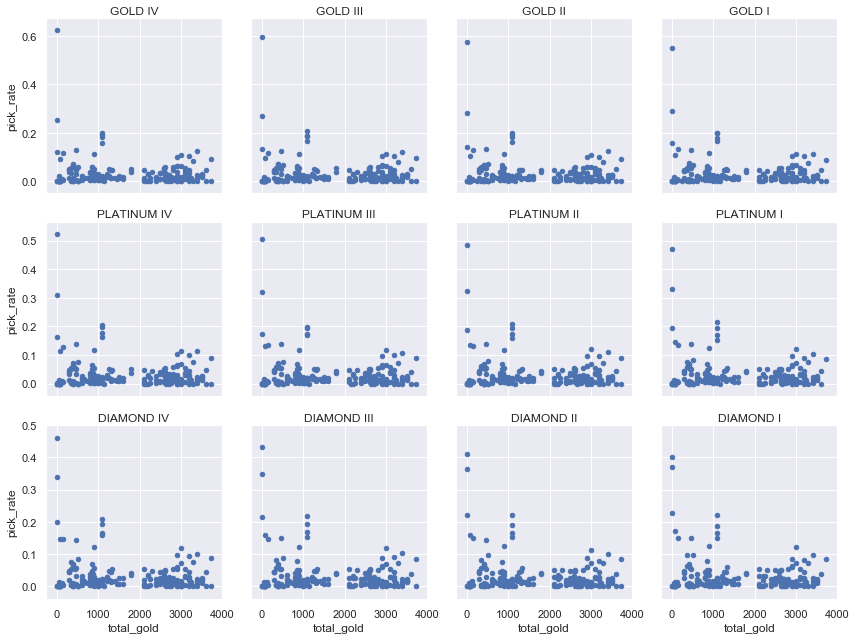

In [65]:
_ = plot_for_each(leagues, divisions, 'scatter', 'pick_rate', 'total_gold', include_item_data=True)
plt.show()

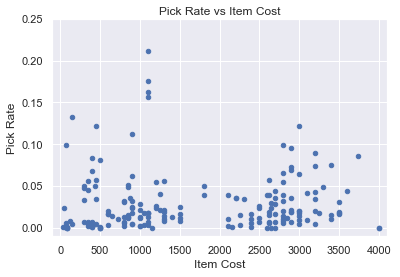

In [176]:
item_occ[(item_occ['total_gold'] != 0)].plot(x='total_gold', y='pick_rate',
                                            title='Pick Rate vs Item Cost', kind='scatter',
                                            xlim=[-100,4100], ylim=[-0.01,0.25])
plt.xlabel('Item Cost')
plt.ylabel('Pick Rate')
plt.savefig('../analysis_images/pick_rate_vs_item_cost.png')

### Champion Spread vs Item Cost

This makes sense, as cheaper items generally have more items to build into, so more champions have items they want to build that involve the cheaper items. Note that the Trinkets are not shown here, as they cost 0, but will probably have a maximal value of Spread at 141.

If we take away the left half of this graph, there is much less correlation between item cost and spread, it seems.

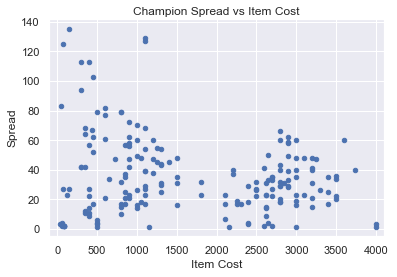

In [177]:
item_occ[(item_occ['total_gold'] != 0)].plot(x='total_gold', y='spread',
                                            title='Champion Spread vs Item Cost', kind='scatter',
                                            xlim=[-100, 4100], ylim=[-5, 142])
plt.xlabel('Item Cost')
plt.ylabel('Spread')
plt.savefig('../analysis_images/champion_spread_vs_item_cost.png')

### Win Rate vs Item Cost

This graph shows that the items in the groups of "full item" (on the right) and "not full item" (on the left) have drastically different average win rates. This is because players with incomplete items will probably be weaker than players with complete items, and at a disadvantage.

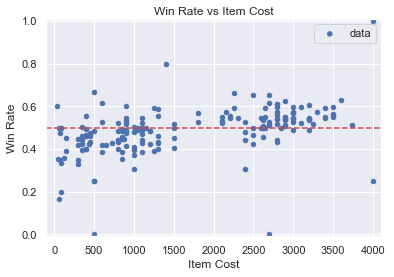

In [178]:
item_occ[(item_occ['total_gold'] != 0)].plot(x='total_gold', y='win_rate',
                                            title='Win Rate vs Item Cost', kind='scatter',
                                            xlim=[-100,4100], ylim=[-0.01,1.01], label='data')
plt.plot(np.linspace(-100, 4100, num = 50),
         np.full(50, 0.5), 'r--', label='50%')
plt.ylabel('Win Rate')
plt.xlabel('Item Cost')
plt.savefig('../analysis_images/win_rate_vs_item_cost.png')

## Tag-Based Statistics

Items can be tagged based on the bonuses they give to the champion (health, attack damage, ability power, etc).

Start looking at item tags and break up the previous plots into those groupings.

The items I want to focus on are the main set of full items. Items that are tagged as Consumable, Lane, Boots, and Trinkets will not be included for now. Other items that don't fall into these groups are in the other no nos, and are edge cases.

In [179]:
consumable = [True if (type(tags) == list and 'Consumable' in tags) else False for tags in item_occ['tags']]

lane_items = [True if (type(tags) == list and 'Lane' in tags) else False for tags in item_occ['tags']]

boots = [True if (type(tags) == list and 'Boots' in tags) else False for tags in item_occ['tags']]

trinkets = [True if (type(tags) == list and 'Trinket' in tags) else False for tags in item_occ['tags']]

other_no_no_ids = [2010, 2057, 2403]
other_edge_cases = [True if id in other_no_no_ids else False for id in item_occ.reset_index()['item_id']]

edge_cases = [cons or lane or other or boot or trinket for cons, lane, other, boot, trinket in
              zip(consumable, lane_items, other_edge_cases, boots, trinkets)]
no_edge_cases = [not case for case in edge_cases]

Make the set of tags for items that aren't any of the above.

In [180]:
tag_list = [tag for tags in item_occ[no_edge_cases]['tags'] if type(tags) != float for tag in tags]
tag_list = set(tag_list)
tag_list.remove('Bilgewater')
tag_list

{u'Active',
 u'Armor',
 u'ArmorPenetration',
 u'AttackSpeed',
 u'Aura',
 u'CooldownReduction',
 u'CriticalStrike',
 u'Damage',
 u'GoldPer',
 u'Health',
 u'HealthRegen',
 u'Jungle',
 u'LifeSteal',
 u'MagicPenetration',
 u'Mana',
 u'ManaRegen',
 u'NonbootsMovement',
 u'OnHit',
 u'Slow',
 u'SpellBlock',
 u'SpellDamage',
 u'SpellVamp',
 u'Vision'}

This function takes a table and a tag and gives the entries that include the given tag.

Below is the table for all items with the Damage tag.

In [181]:
def get_items_of_tag(df, tag):
    if (tag not in tag_list):
        raise ValueError('Could not find ' + tag + ' in the tag list')
    given_tag_list = []
    for tags in df['tags']:
        found_tag = True if type(tags) != float and tag in tags else False
        given_tag_list.append(found_tag)
    return df[given_tag_list]

In [206]:
test_fn_df = get_items_of_tag(item_occ, 'Jungle').sort_values('win_rate', ascending=False)
test_fn_df

count  pick_rate  spread    wins  win_rate                      name  \
item_id                                                                         
2062         2   0.000216       2     1.0  0.500000  Pilfered Potion of Rouge   
3340      5270   0.569730     141  2573.0  0.488235   Warding Totem (Trinket)   
2032        45   0.004865      27    21.0  0.466667           Hunter's Potion   
1039        24   0.002595      11    11.0  0.458333         Hunter's Talisman   
2031      1227   0.132649     135   555.0  0.452323         Refillable Potion   
1041        40   0.004324      12    17.0  0.425000          Hunter's Machete   
3706        22   0.002378      16     9.0  0.409091           Stalker's Blade   
2003       226   0.024432      83    80.0  0.353982             Health Potion   
3715        23   0.002486      14     7.0  0.304348        Skirmisher's Sabre   
2011         1   0.000108       1     0.0  0.000000           Elixir Of Skill   

        full_item  total_gold  \
item_id                         
2062         True        80.0   
3340         True         0.0   
2032         True       400.0   
1039        False       350.0   
2031        False       150.0   
1041        False       350.0   
3706        False      1000.0   
2003         True        50.0   
3715        False      1000.0   
2011         True         0.0   

                                                      tags  
item_id                                                     
2062                            [Consumable, Jungle, Lane]  
3340               [Active, Jungle, Lane, Trinket, Vision]  
2032     [HealthRegen, ManaRegen, Consumable, Active, J...  
1039                 [LifeSteal, ManaRegen, OnHit, Jungle]  
2031       [HealthRegen, Consumable, Active, Lane, Jungle]  
1041                            [LifeSteal, OnHit, Jungle]  
3706     [LifeSteal, ManaRegen, Slow, OnHit, NonbootsMo...  
2003                            [Consumable, Jungle, Lane]  
3715                 [LifeSteal, ManaRegen, OnHit, Jungle]  
2011                            [Consumable, Lane, Jungle]

Most of the complete items have win rates higher than 50%. This makes sense, because players with incomplete items at the end of the game are more likely to be behind, and thus lose.

## Tag-Based Statistics Table

With the function above, I loop over all the tags found in full items and compute descriptive statistics for each tag. I should consider computing stds.

In [184]:
tag_based_stats_df = pd.DataFrame()
for idx, tag in enumerate(tag_list):
    tag_df = get_items_of_tag(item_occ[no_edge_cases], tag)
    tag_based_stats_df.loc[idx, 'tag'] = tag
    tag_based_stats_df.loc[idx, 'pick_count'] = tag_df['count'].sum()
    tag_based_stats_df.loc[idx, 'avg_pick_rate'] = (tag_df['pick_rate'] * tag_df['count']).sum() / tag_df['count'].sum()
    #tag_based_stats_df.loc[idx, 'std_pick_rate'] = tag_df['pick_rate'].std()
    tag_based_stats_df.loc[idx, 'avg_win_rate'] = (tag_df['win_rate'] * tag_df['count']).sum() / tag_df['count'].sum()
    #tag_based_stats_df.loc[idx, 'std_win_rate'] = tag_df['win_rate'].std()
    tag_based_stats_df.loc[idx, 'avg_champ_spread'] = tag_df['spread'].mean()
    tag_based_stats_df.loc[idx, 'avg_item_cost'] = tag_df['total_gold'].mean()

In [185]:
tag_based_stats_df.sort_values('avg_win_rate', ascending=False)

tag  pick_count  avg_pick_rate  avg_win_rate  \
12   MagicPenetration      1171.0       0.044507      0.564475   
16               Aura       896.0       0.022645      0.560268   
13     CriticalStrike      3375.0       0.064845      0.550519   
18             Vision       679.0       0.073405      0.541973   
17        SpellDamage      9634.0       0.047188      0.538821   
19   ArmorPenetration      2981.0       0.080383      0.536397   
3              Damage     11421.0       0.060422      0.534629   
15               Mana      4296.0       0.046418      0.532821   
14              OnHit      8317.0       0.070238      0.532644   
2               Armor      5382.0       0.040696      0.532516   
11             Active      7101.0       0.046221      0.531897   
10          SpellVamp       300.0       0.016320      0.530000   
21   NonbootsMovement      8480.0       0.063088      0.529599   
0   CooldownReduction     12141.0       0.054525      0.526563   
9           LifeSteal      2003.0       0.035959      0.526211   
1         AttackSpeed      5491.0       0.059491      0.526134   
6              Health     10822.0       0.048404      0.516263   
4          SpellBlock      2905.0       0.022449      0.516007   
5                Slow      2558.0       0.036473      0.512901   
7         HealthRegen      4113.0       0.029904      0.507659   
8             GoldPer      1770.0       0.039155      0.503390   
22          ManaRegen      3304.0       0.030615      0.495157   
20             Jungle       109.0       0.003163      0.403670   

    avg_champ_spread  avg_item_cost  
12         38.800000    2830.000000  
16         25.833333    2500.000000  
13         25.750000    2375.000000  
18         33.000000    2900.000000  
17         34.756757    2194.189189  
19         25.400000    2430.000000  
3          32.972973    2451.567568  
15         25.750000    2282.625000  
14         25.307692    2441.653846  
2          41.666667    2068.750000  
11         28.090909    2242.424242  
10         32.000000    3325.000000  
21         28.142857    2426.178571  
0          30.617021    2367.723404  
9          26.769231    2219.230769  
1          26.937500    2314.562500  
6          37.139535    2299.604651  
4          34.681818    2185.000000  
5          34.461538    2473.076923  
7          25.500000    2040.384615  
8          24.666667    1275.000000  
22         18.200000    1763.000000  
20         13.250000     675.000000

In [186]:
tag_based_stats_df.to_csv('../data/tag_based_stats_8.22.1.csv', encoding='utf-8')

### Win Rate vs Tag

This shows that Magic Penetration items have the highest average win rate, and Jungle items have the lowest average win rate.

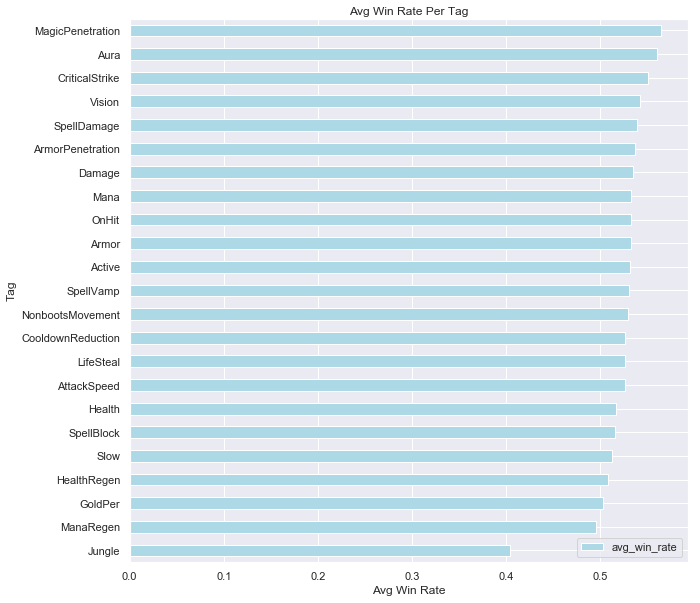

In [187]:
tag_based_stats_df.sort_values('avg_win_rate').plot(x='tag', y='avg_win_rate', kind='barh', figsize=(10,10),
                        color='lightblue', title='Avg Win Rate Per Tag')
plt.ylabel('Tag')
plt.xlabel('Avg Win Rate')
plt.savefig('../analysis_images/avg_win_rate_per_tag.png')

### Pick Rate vs Tag

Armor Penetration Items are picked the most often of any tag, which is surprising. I guess that marksmen, assassins, and fighters can all build some sort of armor pen item. Maybe that makes sense.

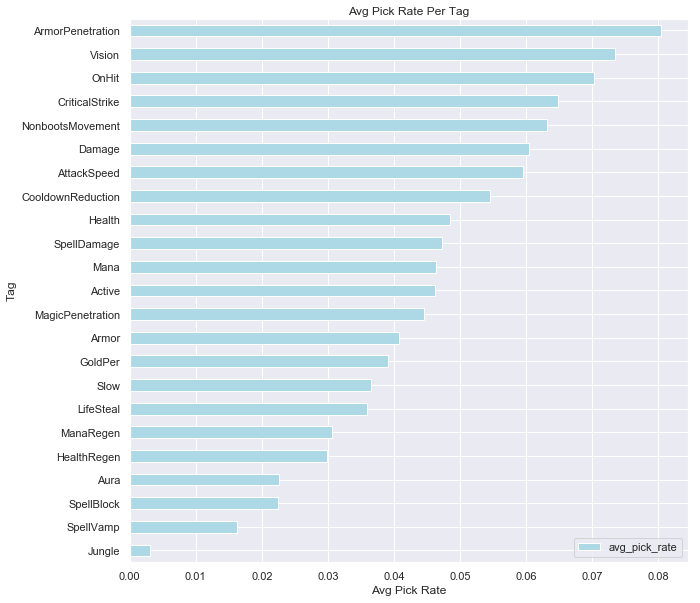

In [188]:
tag_based_stats_df.sort_values('avg_pick_rate').plot(x='tag', y='avg_pick_rate', kind='barh', figsize=(10,10),
                        color='lightblue', title='Avg Pick Rate Per Tag')
plt.ylabel('Tag')
plt.xlabel('Avg Pick Rate')
plt.savefig('../analysis_images/avg_pick_rate_per_tag.png')

### Avg Win Rate vs Avg Item Cost for each Tag

It seems like the tags with more expensive items tend to win more often.

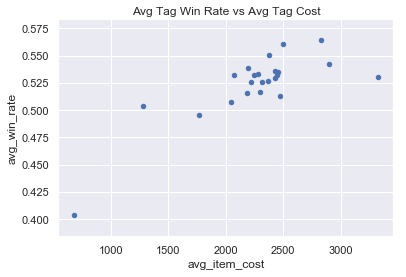

In [189]:
tag_based_stats_df.plot(y='avg_win_rate', x='avg_item_cost', kind='scatter', title='Avg Tag Win Rate vs Avg Tag Cost')

### Avg Pick Rate vs Avg Item Cost for each Tag

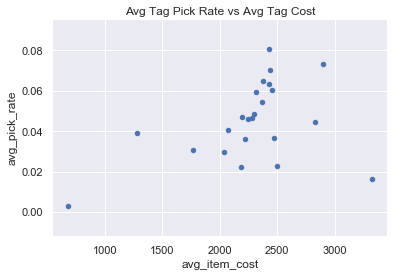

In [190]:
tag_based_stats_df.plot(y='avg_pick_rate', x='avg_item_cost', kind='scatter', title='Avg Tag Pick Rate vs Avg Tag Cost')

### Avg Win Rate vs Avg Pick Rate for each Tag

These values seem to converge as avg pick rate increases.

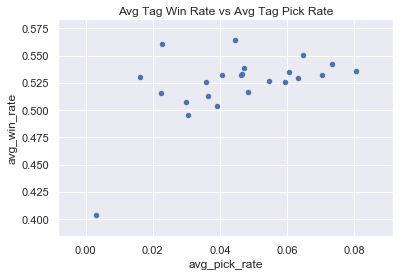

In [191]:
tag_based_stats_df.plot(y='avg_win_rate', x='avg_pick_rate', kind='scatter', title='Avg Tag Win Rate vs Avg Tag Pick Rate')

### Avg Champion Spread vs Avg Pick Rate for each Tag

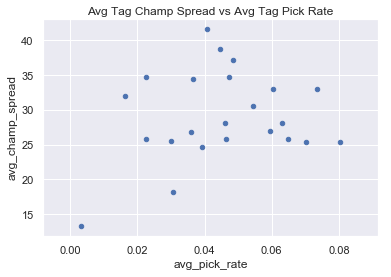

In [192]:
tag_based_stats_df.plot(y='avg_champ_spread', x='avg_pick_rate', kind='scatter',
                        title='Avg Tag Champ Spread vs Avg Tag Pick Rate')

# Build a timing dataframe

Make a dataframe that has individual game data, but one item with its purchase time per row. With NaN values (in purchase_time) there are 64750 rows. After dropna(), there are 52890. This allows me to see when each item was purchased and whether or not the player won with it. This can be used to see if certain items perform better early or late in the game.

Should I put it what item # it is? Does this change if you swap inventory slots, or is it time-ordered?

In [193]:
item_cols = ['stats.item0', 'stats.item1', 'stats.item2', 'stats.item3', 'stats.item4', 'stats.item5', 'stats.item6']
timing_cols = ['item0_time', 'item1_time', 'item2_time', 'item3_time', 'item4_time', 'item5_time', 'item6_time']

timing_df_list = []
for (item, time) in zip(item_cols, timing_cols):
    sub_df = matches_df[[item, time, 'stats.win']]
    sub_df.columns = ['item_id', 'purchase_time', 'win']
    timing_df_list.append(sub_df)

timing_df = pd.concat(timing_df_list).dropna().reset_index(drop=True)
timing_df = timing_df.set_index('item_id').join(items_df[['name', 'full_item', 'total_gold', 'tags']]).reset_index()
timing_df.sort_values('purchase_time').head()

item_id  purchase_time    win          name full_item  total_gold  \
7357     1056         1793.0  False  Doran's Ring      True       400.0   
7992     1056         2001.0   True  Doran's Ring      True       400.0   
8067     1056         2125.0   True  Doran's Ring      True       400.0   
7894     1056         2185.0  False  Doran's Ring      True       400.0   
7740     1056         2241.0   True  Doran's Ring      True       400.0   

                                        tags  
7357  [Health, Lane, ManaRegen, SpellDamage]  
7992  [Health, Lane, ManaRegen, SpellDamage]  
8067  [Health, Lane, ManaRegen, SpellDamage]  
7894  [Health, Lane, ManaRegen, SpellDamage]  
7740  [Health, Lane, ManaRegen, SpellDamage]

In [194]:
timing_df.to_csv('../data/item_timing_8.22.1.csv', encoding='utf-8')

### Item Purchase Time Distribution

This is the overall distribution of purchase times for items that were in a player's inventory when the game ended. If I built the data for all items purchased (and then sold, or overwritten), I would expect more data, especially in the earlier regions of the graph.

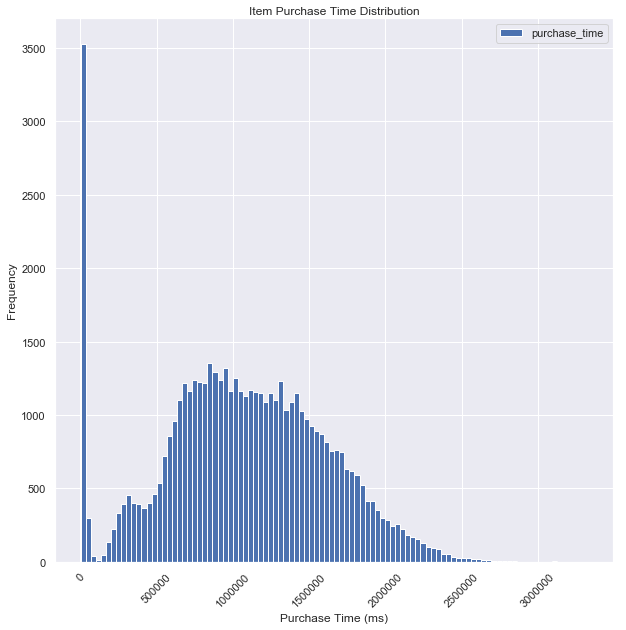

In [195]:
timing_df.plot(y='purchase_time', kind='hist', rot=45, figsize=(10,10), bins=100,
              title='Item Purchase Time Distribution')
plt.xlabel('Purchase Time (ms)')
plt.savefig('../analysis_images/item_purchase_time_dist.png')

### Sample Win Rate vs Purchase Time for the item Stormrazor's Surge

It seems like this item perform better when purchased later in the game.

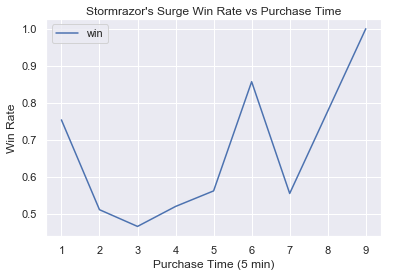

In [196]:
timing_df[timing_df['name'] == 'Stormrazor'].groupby(timing_df['purchase_time'] // 300000).mean().plot(y='win')
plt.title('Stormrazor\'s Surge Win Rate vs Purchase Time')
plt.xlabel('Purchase Time (5 min)')
plt.ylabel('Win Rate')
plt.savefig('../analysis_images/stormrazor_win_rate_vs_purchase_time.png')

purchase time ranges from 1793.0 to 3,328,290.0

In [197]:
tag_labeled_df_list = []

for tag in tag_list:
    timing_tags_df = get_items_of_tag(timing_df, tag)
    timing_tags_df['tag'] = tag
    tag_labeled_df_list.append(timing_tags_df)
#timing_tags_df[timing_tags_df['win'] == True].plot(y='purchase_time', kind='hist', bins=100, ylim=[0,1000])
tag_labeled_df = pd.concat(tag_labeled_df_list)
tag_labeled_df.head()

C:\Users\sebia\Miniconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


item_id  purchase_time    win                name full_item  \
14038     2065      1015088.0   True  Shurelya's Reverie      True   
14039     2065      1745323.0   True  Shurelya's Reverie      True   
14040     2065      1220367.0  False  Shurelya's Reverie      True   
14041     2065      1604704.0   True  Shurelya's Reverie      True   
14042     2065      1610208.0  False  Shurelya's Reverie      True   

       total_gold                                               tags  \
14038      2250.0  [Health, SpellDamage, ManaRegen, Active, Coold...   
14039      2250.0  [Health, SpellDamage, ManaRegen, Active, Coold...   
14040      2250.0  [Health, SpellDamage, ManaRegen, Active, Coold...   
14041      2250.0  [Health, SpellDamage, ManaRegen, Active, Coold...   
14042      2250.0  [Health, SpellDamage, ManaRegen, Active, Coold...   

                     tag  
14038  CooldownReduction  
14039  CooldownReduction  
14040  CooldownReduction  
14041  CooldownReduction  
14042  CooldownReduction

In [198]:
#timing_tags_df.boxplot(column='purchase_time', by='win')

Plot win rate every 5 min? distinguish specific items?

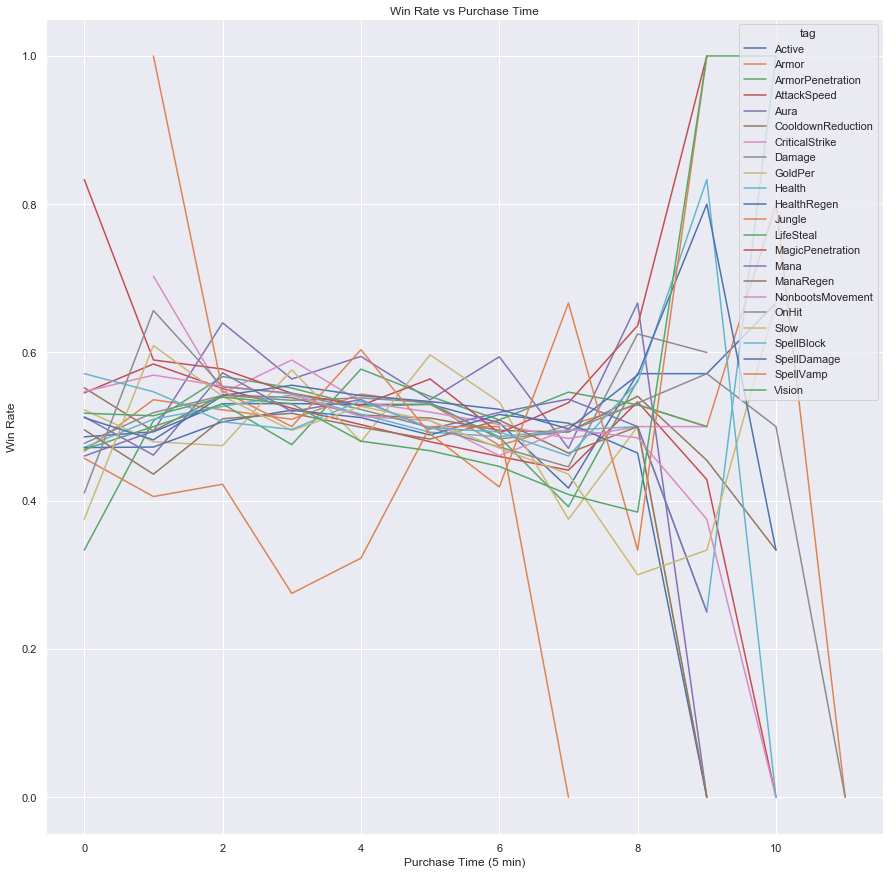

In [199]:
tag_based_time_win_rates = tag_labeled_df.groupby([tag_labeled_df['purchase_time'] // 300000, 'tag']
                                                 ).mean().unstack('tag')[['win']]
tag_based_time_win_rates.plot(y='win', title='Win Rate vs Purchase Time', figsize=(15,15))
plt.xlabel('Purchase Time (5 min)')
plt.ylabel('Win Rate')
plt.show()

This plot is not useful. But it is funny.

### Summary

I have visualized pick rate, win rate, champion spread, and item costs. I have looked at some correlations between these, and examined statistics based on specific kinds / tags of items. 

Pick rate and win rate are the most important statistics. Tag-based statistics are too complicated for now, and I'm not sure what to do with them. Timing data seems very useful, but I am also unsure how I will use that.